In [1]:
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer

In [2]:
class myNN():
    def __init__(self, architecture, learning_rate):
        self.architecture = architecture
        self.learning_rate = learning_rate
        self.params = {}
        self.init_layers()
        self.train_loss_history = []
        self.test_loss_history = []
        
    def init_layers(self):
        #np.random.seed(99)
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            layer_input_size = layer['input_dim']
            layer_output_size = layer['output_dim']
            self.params['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size)*0.1
            self.params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1)*0.1
            #print(self.params['W'+str(layer_index)].shape)
            #print(self.params['W'+str(layer_index)])
            #print(self.params['b'+str(layer_index)])
            #print("*******")
            
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(0,Z)
    
    def linear(self, Z):
        return Z
    
    def sigmoid_backward(self, dA, Z):
        sig = self.sigmoid(Z)
        return dA*sig*(1-sig)
    
    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z<=0] = 0
        return dZ
    
    def linear_backward(self, dA, Z):
        return dA
    
    def single_layer_FP(self, A_prev, W_curr, b_curr, activation='relu'):
        #print(W_curr.shape)
        #print(A_prev.shape)
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        #print(Z_curr.shape)
        #print("------")
        if activation == 'relu':
            activation_func = self.relu
        elif activation == 'sigmoid':
            activation_func = self.sigmoid
        elif activation == 'linear':
            activation_func = self.linear
        else:
            raise Exception('Non-supported activation function')
        return activation_func(Z_curr), Z_curr
    
    def forward_propagation(self, x):
        memory = {}
        A_curr = x
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            A_prev = A_curr
            activation_func = layer['activation']
            W_curr = self.params['W'+str(layer_index)]
            b_curr = self.params['b'+str(layer_index)]
            A_curr, Z_curr = self.single_layer_FP(A_prev, W_curr, b_curr, activation_func)
            memory["A"+str(index)] = A_prev
            memory["Z"+str(layer_index)] = Z_curr
        return A_curr, memory
        
    def get_loss_value(self, y, y_predict):
        #delta = y - y_predict
        #loss = np.dot(delta, delta.T)
        #return np.squeeze(loss)
        return np.power(y_predict - y, 2).sum()
    
    def single_layer_BP(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
        if activation == 'relu':
            activation_func = self.relu_backward
        elif activation == 'sigmoid':
            activation_func = self.sigmoid_backward
        elif activation == 'linear':
            activation_func = self.linear_backward
        else:
            raise Exception('Non-supported activation function')
        dZ_curr = activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T)
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)
        dA_prev = np.dot(W_curr.T, dZ_curr)
        return dA_prev, dW_curr, db_curr
    
    def back_propagation(self, y_predict, y, memory):
        grads_values = {}
        dA_prev = 2*(y_predict-y)
        #dA_prev = delta * np.ones(y.shape).reshape(1,-1)
        for layer_prev_index, layer in reversed(list(enumerate(self.architecture))):
            layer_cur_index = layer_prev_index+1
            activation_func = layer['activation']
            dA_curr = dA_prev
            A_prev = memory['A' + str(layer_prev_index)]
            Z_curr = memory['Z' + str(layer_cur_index)]
            W_curr = self.params['W'+str(layer_cur_index)]
            b_curr = self.params['b'+str(layer_cur_index)]
            dA_prev, dW_curr, db_curr = self.single_layer_BP(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_func)
            grads_values['dW'+str(layer_cur_index)] = dW_curr
            grads_values['db'+str(layer_cur_index)] = db_curr
        return grads_values
    
    def update(self, grads_values):
        for index, layer in enumerate(self.architecture):
            layer_idx = index + 1
            self.params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
            self.params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
    
    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size=16):
        for i in range(epochs):
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(0 ,x_train.shape[0], batch_size):
                start = j
                end = j+batch_size
                if end >= x_train.shape[0]:
                    end = x_train.shape[0]-1
                x_min = x_train[start:end]
                y_min = y_train[start:end]
                y_predict, memory = self.forward_propagation(x_min.T)
                loss = self.get_loss_value(np.array([y_min]), y_predict)
                grads_values = self.back_propagation(y_predict, np.array([y_min]), memory)
                self.update(grads_values)
            y_train_predict = self.predict(x_train.T)
            y_test_predict = self.predict(x_test.T)
            train_loss = self.get_loss_value(np.array([y_train]), y_train_predict)
            test_loss = self.get_loss_value(np.array([y_test]), y_test_predict)
            train_acc = self.accuracy(np.array([y_train]), y_train_predict)
            test_acc = self.accuracy(np.array([y_test]), y_test_predict)
            self.train_loss_history.append(train_loss)
            self.test_loss_history.append(test_loss)
            if (i+1) % 100 == 0:
                print("Eposh : %4d/%d || training loss : %lf || training eval : %lf" % (i+1, epochs, train_loss, train_acc),end=" ")
                print("|| testing loss : %lf || testing eval : %lf" % (test_loss, test_acc))
    
    def show_parm(self):
        print(self.params)
    
    def accuracy(self, y, y_predict):
        power = np.power(y_predict - y, 2).mean()
        return np.sqrt(power)
    
    def predict(self, x):
        y_predict, memory = self.forward_propagation(x)
        return np.squeeze(y_predict)
    
    def get_loss_history(self):
        return self.train_loss_history, self.test_loss_history

In [3]:
def show_graph(d1, d2, labels, length = 0, locs='upper left'):
    t = range(len(d1))
    if length != 0:
        plt.plot(t[:length],d1[:length], 'r', label=labels[0])
        plt.plot(t[:length],d2[:length], 'b', label=labels[1])
    else:
        plt.plot(t, d1, 'r', label=labels[0])
        plt.plot(t, d2, 'b', label=labels[1])
    plt.legend(loc=locs)
    plt.show()

In [4]:
def my_split_function(data, label, test_size):
    #random.seed(500)
    #data, label = shuffle(data, label)
    train_len = int(len(data)*(1-test_size))
    return (data[:train_len], data[train_len:], label[:train_len], label[train_len:])

In [5]:
# https://quantdare.com/create-your-own-deep-learning-framework-using-numpy/
# https://www.itread01.com/feffx.html
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
nn_architecture = [
    {"input_dim": 16, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.0000001

In [6]:
# Orientation category : 2, 3, 4, 5
# Glazing Area Distribution : 0, 1, 2, 3, 4, 5
data = pd.read_csv('energy_efficiency_data.csv')
heating = data.pop('Heating Load')
cooling = data.pop('Cooling Load')

In [7]:
# for one hot encoding
#Orient = pd.get_dummies(data['Orientation'])
#Glazing = pd.get_dummies(data['Glazing Area Distribution'])
data = pd.concat([data,pd.get_dummies(data['Orientation'], prefix='Orientation')],axis=1)
data = pd.concat([data,pd.get_dummies(data['Glazing Area Distribution'], prefix='Glazing Area Distribution')],axis=1)
data.drop(['Orientation'],axis=1, inplace=True)
data.drop(['Glazing Area Distribution'],axis=1, inplace=True)

In [8]:
# split data
#data = Normalizer(norm='l1').fit_transform(data)
x_train, x_test, y_train, y_test = my_split_function(data.to_numpy(), heating.to_numpy(), test_size=0.25)

In [9]:
model = myNN(nn_architecture, learning_rate)

In [10]:
model.train(x_train, np.array(y_train), x_test, np.array(y_test), 2000, batch_size=16)

Eposh :  100/2000 || training loss : 18881.353674 || training eval : 5.725393 || testing loss : 6337.447572 || testing eval : 5.745219
Eposh :  200/2000 || training loss : 17030.812107 || training eval : 5.437590 || testing loss : 5722.973430 || testing eval : 5.459593
Eposh :  300/2000 || training loss : 16295.895996 || training eval : 5.318974 || testing loss : 5479.408299 || testing eval : 5.342152
Eposh :  400/2000 || training loss : 15664.802469 || training eval : 5.214963 || testing loss : 5260.596814 || testing eval : 5.234400
Eposh :  500/2000 || training loss : 14759.526985 || training eval : 5.062033 || testing loss : 4972.046574 || testing eval : 5.088819
Eposh :  600/2000 || training loss : 13841.669052 || training eval : 4.902109 || testing loss : 4656.685072 || testing eval : 4.924791
Eposh :  700/2000 || training loss : 12808.941714 || training eval : 4.715691 || testing loss : 4318.333133 || testing eval : 4.742501
Eposh :  800/2000 || training loss : 11924.063039 || tr

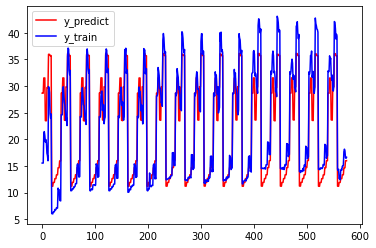

In [11]:
y_predict = model.predict(x_train.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_train, ['y_predict', 'y_train'])

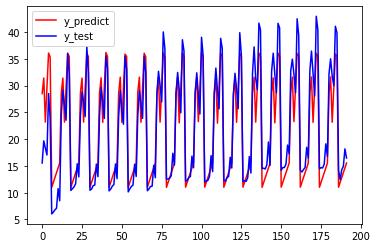

In [156]:
y_predict = model.predict(x_test.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_test, ['y_predict', 'y_test'])

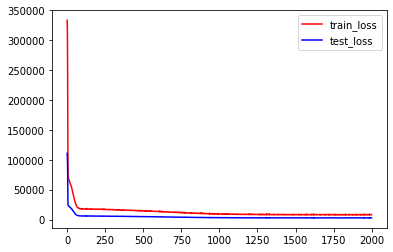

In [157]:
train_loss, test_loss = model.get_loss_history()
t = range(len(train_loss))
show_graph(train_loss, test_loss, ['train_loss', 'test_loss'], locs='upper right')

In [182]:
# calculate correction
# we need to pop the categorical feature beacuse I think it can't be calculated with corr
data = pd.read_csv('energy_efficiency_data.csv')
data.pop('Orientation')
data.pop('Glazing Area Distribution')
data.corr()

,# Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Heating Load,Cooling Load
# Relative Compactness,1.000000e+00,-9.919015e-01,-2.037817e-01,-8.688234e-01,8.277473e-01,-3.209966e-18,0.622272,0.634339
Surface Area,-9.919015e-01,1.000000e+00,1.955016e-01,8.807195e-01,-8.581477e-01,3.631399e-17,-0.658120,-0.672999
Wall Area,-2.037817e-01,1.955016e-01,1.000000e+00,-2.923165e-01,2.809757e-01,1.036064e-17,0.455671,0.427117
Roof Area,-8.688234e-01,8.807195e-01,-2.923165e-01,1.000000e+00,-9.725122e-01,5.581108e-17,-0.861828,-0.862547
Overall Height,8.277473e-01,-8.581477e-01,2.809757e-01,-9.725122e-01,1.000000e+00,-2.481890e-18,0.889431,0.895785
Glazing Area,-3.209966e-18,3.631399e-17,1.036064e-17,5.581108e-17,-2.481890e-18,1.000000e+00,0.269841,0.207505
Heating Load,6.222722e-01,-6.581202e-01,4.556712e-01,-8.618283e-01,8.894307e-01,2.698410e-01,1.000000,0.975862
Cooling Load,6.343391e-01,-6.729989e-01,4.271170e-01,-8.625466e-01,8.957852e-01,2.075050e-01,0.975862,1.000000


In [183]:
# we choose higer corr such about Roof Area, Overall Height, Surface Aread
data.pop('# Relative Compactness')
data.pop('Wall Area')
data.pop('Glazing Area')
data.pop('Cooling Load')
print(data)
heating = data.pop('Heating Load')

     Surface Area  Roof Area  Overall Height  Heating Load
0           514.5     110.25             7.0         15.55
1           514.5     110.25             7.0         15.55
2           514.5     110.25             7.0         15.55
3           563.5     122.50             7.0         20.84
4           563.5     122.50             7.0         21.46
..            ...        ...             ...           ...
763         710.5     220.50             3.5         12.43
764         735.0     220.50             3.5         14.28
765         759.5     220.50             3.5         14.92
766         784.0     220.50             3.5         18.19
767         808.5     220.50             3.5         16.48

[768 rows x 4 columns]


In [189]:
nn_architecture = [
    {"input_dim": 3, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.0000001
x_train, x_test, y_train, y_test = my_split_function(data.to_numpy(), heating.to_numpy(), test_size=0.25)
model = myNN(nn_architecture, learning_rate)

In [190]:
model.train(x_train, np.array(y_train), x_test, np.array(y_test), 2000, batch_size=16)

Eposh :  100/2000 || training loss : 62397.401186 || training eval : 10.408113 || testing loss : 20813.913644 || testing eval : 10.411811
Eposh :  200/2000 || training loss : 19337.456455 || training eval : 5.794133 || testing loss : 6461.010316 || testing eval : 5.800956
Eposh :  300/2000 || training loss : 17716.020256 || training eval : 5.545898 || testing loss : 5946.513436 || testing eval : 5.565198
Eposh :  400/2000 || training loss : 17834.805247 || training eval : 5.564459 || testing loss : 5975.420976 || testing eval : 5.578708
Eposh :  500/2000 || training loss : 17380.145721 || training eval : 5.493074 || testing loss : 5835.528082 || testing eval : 5.513019
Eposh :  600/2000 || training loss : 17899.294125 || training eval : 5.574510 || testing loss : 5990.202611 || testing eval : 5.585604
Eposh :  700/2000 || training loss : 17162.757011 || training eval : 5.458613 || testing loss : 5774.650268 || testing eval : 5.484187
Eposh :  800/2000 || training loss : 16753.412709 ||

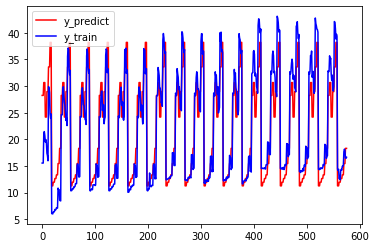

In [191]:
y_predict = model.predict(x_train.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_train, ['y_predict', 'y_train'])

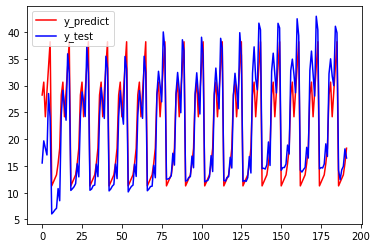

In [192]:
y_predict = model.predict(x_test.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_test, ['y_predict', 'y_test'])

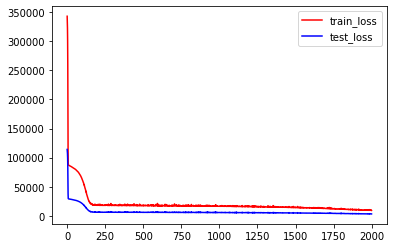

In [193]:
train_loss, test_loss = model.get_loss_history()
t = range(len(train_loss))
show_graph(train_loss, test_loss, ['train_loss', 'test_loss'], locs='upper right')

In [135]:
data = pd.read_csv('energy_efficiency_data.csv')
data.pop('Orientation')
data.pop('Glazing Area Distribution')
data.pop('Roof Area')
data.pop('Surface Area')
data.pop('Overall Height')
data.pop('Cooling Load')
print(data)
heating = data.pop('Heating Load')

     # Relative Compactness  Wall Area  Glazing Area  Heating Load
0                      0.98      294.0           0.0         15.55
1                      0.98      294.0           0.0         15.55
2                      0.98      294.0           0.0         15.55
3                      0.90      318.5           0.0         20.84
4                      0.90      318.5           0.0         21.46
..                      ...        ...           ...           ...
763                    0.71      269.5           0.4         12.43
764                    0.69      294.0           0.4         14.28
765                    0.66      318.5           0.4         14.92
766                    0.64      343.0           0.4         18.19
767                    0.62      367.5           0.4         16.48

[768 rows x 4 columns]


In [136]:
nn_architecture = [
    {"input_dim": 3, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.0000001
x_train, x_test, y_train, y_test = my_split_function(data.to_numpy(), heating.to_numpy(), test_size=0.25)
model = myNN(nn_architecture, learning_rate)

In [139]:
model.train(x_train, np.array(y_train), x_test, np.array(y_test), 5000, batch_size=16)

Eposh :  100/5000 || training loss : 47738.416196 || training eval : 9.103801 || testing loss : 15950.187784 || testing eval : 9.114488
Eposh :  200/5000 || training loss : 47736.853243 || training eval : 9.103652 || testing loss : 15949.794739 || testing eval : 9.114376
Eposh :  300/5000 || training loss : 47739.821342 || training eval : 9.103935 || testing loss : 15950.047217 || testing eval : 9.114448
Eposh :  400/5000 || training loss : 47740.918642 || training eval : 9.104040 || testing loss : 15950.129979 || testing eval : 9.114472
Eposh :  500/5000 || training loss : 47731.870118 || training eval : 9.103177 || testing loss : 15949.145293 || testing eval : 9.114190
Eposh :  600/5000 || training loss : 47730.854974 || training eval : 9.103080 || testing loss : 15948.863865 || testing eval : 9.114110
Eposh :  700/5000 || training loss : 47731.425620 || training eval : 9.103135 || testing loss : 15949.876781 || testing eval : 9.114399
Eposh :  800/5000 || training loss : 47728.86509

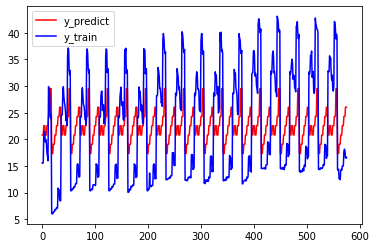

In [141]:
y_predict = model.predict(x_train.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_train, ['y_predict', 'y_train'])

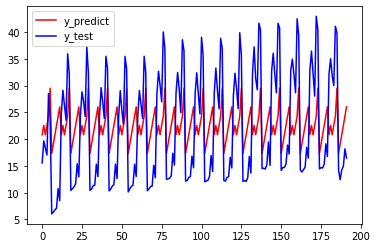

In [140]:
y_predict = model.predict(x_test.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_test, ['y_predict', 'y_test'])

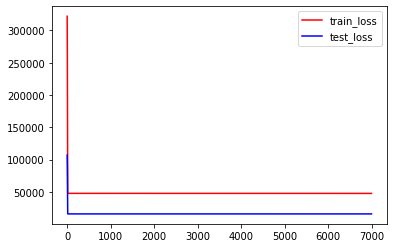

In [142]:
train_loss, test_loss = model.get_loss_history()
t = range(len(train_loss))
show_graph(train_loss, test_loss, ['train_loss', 'test_loss'], locs='upper right')

In [129]:
# if we think the cacategorical features are also import feature
data = pd.read_csv('energy_efficiency_data.csv')
Orient = pd.get_dummies(data['Orientation'])
Glazing = pd.get_dummies(data['Glazing Area Distribution'])
data = pd.concat([data,pd.get_dummies(data['Orientation'], prefix='Orientation')],axis=1)
data = pd.concat([data,pd.get_dummies(data['Glazing Area Distribution'], prefix='Glazing Area Distribution')],axis=1)
data.drop(['Orientation'],axis=1, inplace=True)
data.drop(['Glazing Area Distribution'],axis=1, inplace=True)
data.pop('# Relative Compactness')
data.pop('Wall Area')
data.pop('Glazing Area')
data.pop('Cooling Load')
heating = data.pop('Heating Load')

In [130]:
nn_architecture = [
    {"input_dim": 13, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.0000001
x_train, x_test, y_train, y_test = my_split_function(data.to_numpy(), heating.to_numpy(), test_size=0.25)
model = myNN(nn_architecture, learning_rate)

In [131]:
model.train(x_train, np.array(y_train), x_test, np.array(y_test), 2000, batch_size=16)

Eposh :  100/2000 || training loss : 73526.252166 || training eval : 11.298219 || testing loss : 24527.842750 || testing eval : 11.302618
Eposh :  200/2000 || training loss : 17710.893249 || training eval : 5.545095 || testing loss : 5940.017893 || testing eval : 5.562157
Eposh :  300/2000 || training loss : 16455.747551 || training eval : 5.344998 || testing loss : 5514.576336 || testing eval : 5.359268
Eposh :  400/2000 || training loss : 15385.196714 || training eval : 5.168212 || testing loss : 5181.811339 || testing eval : 5.195055
Eposh :  500/2000 || training loss : 14624.543760 || training eval : 5.038832 || testing loss : 4926.274119 || testing eval : 5.065341
Eposh :  600/2000 || training loss : 15085.760335 || training eval : 5.117671 || testing loss : 5046.131248 || testing eval : 5.126591
Eposh :  700/2000 || training loss : 13158.972830 || training eval : 4.779690 || testing loss : 4446.160821 || testing eval : 4.812181
Eposh :  800/2000 || training loss : 12149.058639 ||

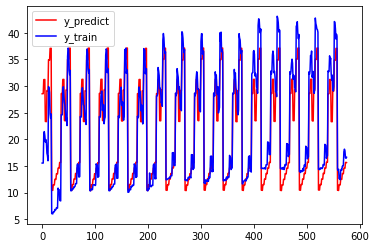

In [132]:
y_predict = model.predict(x_train.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_train, ['y_predict', 'y_train'])

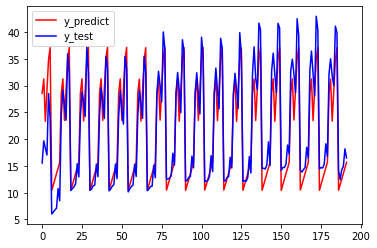

In [133]:
y_predict = model.predict(x_test.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_test, ['y_predict', 'y_test'])

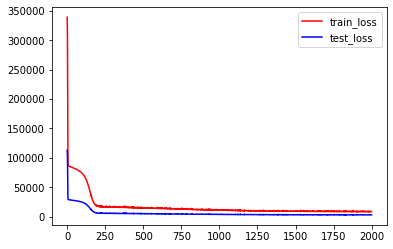

In [134]:
train_loss, test_loss = model.get_loss_history()
t = range(len(train_loss))
show_graph(train_loss, test_loss, ['train_loss', 'test_loss'], locs='upper right')